## 教程 - 0: 连续前向Burgers方程

欢迎来到我们关于物理信息神经网络（PINNs）的第一个教程，使用我们的新包 **`pinnsjax`**！本指南旨在向您介绍通过PINNs将深度学习和科学计算相结合的方法，该方法将物理定律嵌入到神经网络训练中。

#### 概述：

- **网格生成和采样：** 了解如何创建和使用网格来训练PINNs，这对于定义问题的域至关重要。
- **基于PINNs的神经网络模型：** 如何构建和组织神经网络以集成物理定律。
- **神经网络中的物理定律：** 使用 `pde_fn` 和 `output_fn` 详细说明网络内微分方程的实现。
- **训练和验证：** 利用我们的Trainer来训练模型，包括定义训练数据、初始条件以及处理边界条件。
- **结果可视化：** 保存和分析PINN模型的结果。

#### 安装 `pinnsjax`

In [1]:
#%pip install pinnsjax

#### 导入库

In [2]:
from typing import Dict

import jax
import numpy as np

import pinnsjax

### 定义网格

物理信息神经网络（PINNs）需要一个离散化域（网格）来求解物理方程。在 `pinnsjax` 中，主要有两种方法来定义这个网格：


- **分别定义时间和空间域：** 这里，我们使用 `pinnsjax.data.TimeDomain` 来创建时间域和 `pinnsjax.data.Interval` 来创建1-D空间域。然后这些域被用来定义一个 `pinnsjax.data.Mesh`。

- **定义点云：** 这种方法直接利用时空数据（例如，来自实验或其他模拟）来使用 `pinnsjax.data.PointCloud` 创建网格。

这两种方法理想情况下应该产生相同的结果。

#### 选项1：使用分离的时间和空间域定义网格

我们首先定义一个函数来读取和预处理来自文件的解数据。输出应该是一个字典。

In [3]:
def read_data_fn(root_path):
    """从指定的根路径读取和预处理数据。

    :param root_path: 数据文件应该位于的根目录。
    :return: 处理后的数据将在Mesh类中使用。
    """

    # 从指定路径加载Burgers方程的数据文件
    data = pinnsjax.utils.load_data(root_path, "burgers_shock.mat")
    # 提取精确解的实部，避免复数解
    exact_u = np.real(data["usol"])
    # 返回包含解的字典，键名为"u"
    return {"u": exact_u}

现在，为网格生成定义时间和空间域。这些参数的选择取决于要解决的特定问题，应相应设置。

In [4]:
# 定义时间域：从0到0.99的时间区间，共100个时间点
time_domain = pinnsjax.data.TimeDomain(t_interval=[0, 0.99], t_points = 100)
# 定义空间域：从-1到1的一维空间区间，共256个空间点
spatial_domain = pinnsjax.data.Interval(x_interval=[-1, 1], shape = 256)

然后使用时间和空间域以及read_data_fn函数定义网格。

In [5]:
mesh = pinnsjax.data.Mesh(root_dir = 'data',  # 指定数据文件所在的根目录
                          read_data_fn = read_data_fn,  # 传入读取数据的函数
                          spatial_domain = spatial_domain,  # 传入之前定义的空间域
                          time_domain = time_domain)  # 传入之前定义的时间域

#### 选项2：使用点云

对于直接可获得空间和时间数据以及解的情况（例如，来自实验测量），我们可以使用 `pinnsjax.data.PointCloud` 创建网格。

**注意：** 正确格式化空间和时间域维度至关重要。具体来说：

- **空间域：** 每个轴应以 $(N \times 1)$ 的形状构建，其中 $N$ 表示空间点的数量。
- **时间域：** 这应该格式化为 $(T \times 1)$，其中 $T$ 表示时间步的数量。
- **解数据：** 每个解（例如温度、速度）应为 $(N \times T)$ 的形状，与空间和时间点对齐。

In [6]:
def read_data_fn(root_path):
    """从指定的根路径读取和预处理数据。

    :param root_path: 数据文件应该位于的根目录。
    :return: 处理后的数据将在PointCloud类中使用。
    """

    data = pinnsjax.utils.load_data(root_path, "burgers_shock.mat")

    x = data['x']
    t = data['t']
    exact_u = np.real(data["usol"])
    
    return pinnsjax.data.PointCloudData(
        spatial=[x], time=[t], solution={"u": exact_u}
    )

现在，可以使用该函数和数据文件夹的目录初始化网格。

In [7]:
mesh = pinnsjax.data.PointCloud(root_dir='./data',
                                read_data_fn=read_data_fn)

### 定义训练数据集

对于求解Burgers偏微分方程，我们有：
- 初始条件
- 狄利克雷边界条件
- PDE的采集点。

#### 初始条件

让我们从Burgers方程的初始条件开始。
$$ u(0, x) = -\sin(\pi x) $$

对于定义初始条件，我们同样有两个选择。

- **从数据中采样。**
- **定义一个计算初始条件的函数。**

##### 设置样本数量

In [8]:
N0 = 50

##### 选项1：从数据中采样

In [9]:
in_c = pinnsjax.data.InitialCondition(mesh = mesh,
                                      num_sample = N0,
                                      solution = ['u'])

##### 选项2：定义一个计算初始条件的函数

`initial_fun` 的输入应该与问题的空间域相同。

In [10]:
def initial_fun(x):
    return {'u': - np.sin(x*np.pi)}

In [11]:
in_c = pinnsjax.data.InitialCondition(mesh = mesh,
                                      num_sample = N0,
                                      initial_fun = initial_fun,
                                      solution = ['u'])

`pinnsjax.data.InitialCondition` 中的 `solution` 属性指定了要采样的解（在我们的例子中是 `u`），用于初始条件。

#### 周期边界条件

`pinnsjax.data.DirichletBoundaryCondition` 用于指定函数在域中特定点或边界处的固定值。在我们的例子中，对于Burgers方程，我们有：

$$ u(t,-1) = u(t, 1) = 0 $$

In [12]:
N_b = 50
di_b = pinnsjax.data.DirichletBoundaryCondition(mesh = mesh,
                                                num_sample = N_b,
                                                solution = ['u'])

#### 用于采集点和解的网格采样器

在我们的问题中，描述动力学的偏微分方程（PDEs）如下：

$$ f_u := u_t + uu_x - (0.01/\pi)u_{xx}$$

为了使用神经网络找到这些PDEs的解，我们必须从域中采样点，在这些点上网络将被训练以满足这些方程。这个采样过程对于训练我们的PINN至关重要。我们使用 `pinnsjax.data.MeshSampler` 来实现这一目的，指定以下内容：

- **采样点数量 (N_f)：** 我们选择从域中采样20,000个点。这个数字是计算效率和捕捉PDEs动态需要足够密集采样之间的平衡。
- **网格 (mesh)：** 这个参数定义了将从中采样点的时空域。
- **采集点：** 我们定义 `['f_u']` 作为我们采集点的目标。这些不是神经网络的直接输出，而是从网络输出及其导数派生的（我们稍后将定义 `pde_fn` 函数）。PINN将被训练，使这些表达式趋向于零，与PDE约束对齐。

以下是实现这个采样器的代码：

In [13]:
N_f = 20000
me_s = pinnsjax.data.MeshSampler(mesh = mesh,
                                 num_sample = N_f,
                                 collection_points = ['f_u'])

### 定义验证数据集

对于验证，我们从网格中采样所有点来全面评估我们的模型。模型将针对 `u` 的解进行验证。

**注意：** 如果未指定 `num_sample`，采样器将使用整个网格。

In [14]:
val_s = pinnsjax.data.MeshSampler(mesh = mesh,
                                  solution = ['u'])

### 定义神经网络

在这里，我们尝试定义一个用于解决问题的神经网络。为了定义神经网络，我们应该设置层数和输出的名称。还应该定义域边界。`lb` 和 `ub` 参数表示时空域的下界和上界，有助于规范化网络的输入。因此，该网络的输入是 `x` 和 `t`，输出是 `u`。

In [15]:
net = pinnsjax.models.FCN(layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1],
                          output_names = ['u'],
                          lb=mesh.lb,
                          ub=mesh.ub)

### 定义 `pde_fn` 函数

现在，我们定义 `pde_fn`。
- **`pde_fn`：** 制定PDE约束，这将被 `MeshSampler` 用于计算收集点处的损失。

#### `pde_fn` 函数

**注意：** `pde_fn` 应始终有五个输入：
- **功能模型：** 这是神经网络或任何其他功能近似模型，用于使用JAX自动微分计算梯度。
- **模型参数：** 包括模型的所有可训练参数以及反问题所需的任何其他参数。
- **输出：** 网络的输出，通常是一个字典。对于Burgers方程，这个字典应该至少有一个键 `u` 表示函数 `u(t, x)`。
- **空间域：** 这些是空间域变量。在我们的例子中，由于我们的问题有1-D空间域，输入只有 `x`。例如，如果我们有2-D空间，我们需要为该维度增加另一个输入。例如，输入从 `(functional_model, params, outputs, x, t)` 将变为 `(functional_model, params, outputs, x, y, t)`。
- **时间域：** `pde_fn` 函数的最后一个输入始终应该是时间。

In [16]:
def pde_fn(functional_model,
           params,
           outputs: Dict[str, jax.Array],
           x: jax.Array,
           t: jax.Array):   
    """定义偏微分方程(PDEs)。"""

    # 计算u对x和t的一阶偏导数
    u_x, u_t = pinnsjax.utils.gradient(
        functional_model, 
        argnums=(1, 2), 
        order=1
    )(params, x, t, 'u')
    
    # 计算u对x的二阶偏导数
    u_xx = pinnsjax.utils.gradient(
        functional_model, 
        argnums=1, 
        order=2
    )(params, x, t, 'u')[0]

    outputs["f_u"] = u_t + outputs["u"] * u_x - (0.01 / np.pi) * u_xx

    return outputs

### 定义PINNDataModule和PINNModule

为了与Lightning集成，我们使用两个专门的模块：

- `PINNDataModule` 管理数据。
- `PINNModule` 处理模型和编译。

#### 定义 `PINNDataModule`
在这里，我们将收集点、初始条件和周期边界条件定义为训练数据集，并设置验证集。`PINNDataModule` 用于定义训练、验证、预测和测试数据集。

In [17]:
train_datasets = [me_s, in_c, di_b]
val_dataset = val_s
datamodule = pinnsjax.data.PINNDataModule(train_datasets = train_datasets,
                                          val_dataset = val_dataset,
                                          pred_dataset = val_s)

#### 定义 `PINNModule`

`PINNModule` 处理几个事项。在这里，我们将探讨这个类的输入：

- **net：** 用于近似解的神经网络模型。
- **pde_fn：** 定义要解决的PDE的偏微分方程函数。
- **optimizer：** （可选）用于训练神经网络的优化器。默认是Adam。
- **loss_fn：** （可选）要使用的损失函数，"sse" 或 "mse"。默认是 "sse"。
- **extra_variables：** （可选）反问题中的额外变量。默认是None。
- **runge_kutta：** （可选）在离散模式下解PDEs的龙格-库塔方法。默认是None。
- **jit_compile：** （可选）启用JIT编译的标志。默认是True。

在此示例中，我们使用定义的变量初始化 `PINNModule`。我们设置Adam优化器，并尝试使用XLA编译器编译模型。这里的损失函数是均方误差（MSE）。

In [18]:
model = pinnsjax.models.PINNModule(net = net,
                                   pde_fn = pde_fn,
                                   loss_fn = 'mse')

### 设置训练器

为了训练我们的模型，我们编写自定义训练器。您可以设置的参数包括：

- **max_epochs：** 最大训练轮数。
- **check_val_every_n_epoch：** （可选）在轮次内验证检查的频率。默认为1。
- **enable_progress_bar：** （可选）启用/禁用进度条的标志。默认为True。


In [19]:
trainer = pinnsjax.Trainer(max_epochs=1000, check_val_every_n_epoch=100)

### 训练

In [20]:
trainer.fit(model=model, datamodule=datamodule)

1000/1000 100%|██████████|[已用时间: 03:16, 剩余时间: 00:00,  5.10it/s, val/loss: 0.0312, val/error_u: 0.2877, train/loss: 0.0203: ]


### 验证

In [21]:
trainer.validate(model=model, datamodule=datamodule)

(Array(0.02648816, dtype=float32), {'u': Array(0.2649225, dtype=float32)})

### 绘图

对于绘图，我们需要预测结果，然后我们应该连接结果。

In [22]:
preds_dict = trainer.predict(model=model, datamodule=datamodule)

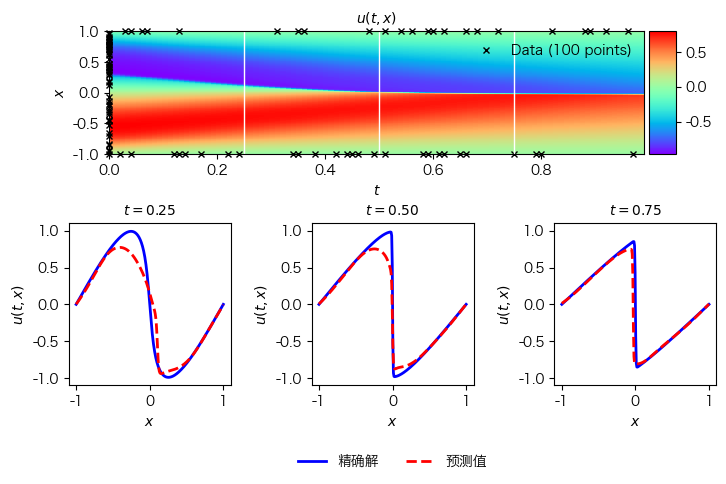

In [23]:
for sol_key, pred in preds_dict.items():
    preds_dict[sol_key] = pred
pinnsjax.utils.plot_burgers_continuous_forward(mesh=mesh,
                                               preds=preds_dict,
                                               train_datasets=train_datasets,
                                               val_dataset=val_dataset,
                                               file_name='out')